In [1]:
%load_ext autoreload


In [2]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%aimport Variant_analysis_helper_functions


In [3]:
# Listing ENSTs with gnomad variants
gnomad_var_ENSTs = glob.glob("../outputs/mutations/cds_gnomad_snv_classified/ENST*")
gnomad_var_ENSTs = [_.split("/")[-1][:-4] for _ in gnomad_var_ENSTs]
gnomad_var_ENSTs[:5]

['ENST00000356073',
 'ENST00000348066',
 'ENST00000379044',
 'ENST00000246672',
 'ENST00000288319']

In [4]:
# Listing ENSTs with spark vars
spark_var_ENSTs =  glob.glob("../outputs/mutations/cds_expanded_iWES_v2_variants_snv_classified/ENST*")
spark_var_ENSTs = [_.split("/")[-1][:-4] for _ in spark_var_ENSTs]
spark_var_ENSTs[:5]

['ENST00000296096',
 'ENST00000419098',
 'ENST00000259803',
 'ENST00000698516',
 'ENST00000506184']

In [5]:
ENSTs = set(gnomad_var_ENSTs) & set(spark_var_ENSTs)
ENSTs

{'ENST00000056233',
 'ENST00000239243',
 'ENST00000241001',
 'ENST00000246672',
 'ENST00000250916',
 'ENST00000262238',
 'ENST00000262518',
 'ENST00000264637',
 'ENST00000265340',
 'ENST00000282549',
 'ENST00000288319',
 'ENST00000303329',
 'ENST00000309446',
 'ENST00000312233',
 'ENST00000315869',
 'ENST00000317216',
 'ENST00000318003',
 'ENST00000331340',
 'ENST00000335670',
 'ENST00000339562',
 'ENST00000341099',
 'ENST00000342988',
 'ENST00000348066',
 'ENST00000348332',
 'ENST00000355311',
 'ENST00000355995',
 'ENST00000356073',
 'ENST00000358127',
 'ENST00000359486',
 'ENST00000367265',
 'ENST00000372583',
 'ENST00000373036',
 'ENST00000373294',
 'ENST00000377022',
 'ENST00000377142',
 'ENST00000379044',
 'ENST00000380013',
 'ENST00000389506',
 'ENST00000395324',
 'ENST00000403491',
 'ENST00000428368',
 'ENST00000434704',
 'ENST00000437473',
 'ENST00000561208',
 'ENST00000592199'}

In [8]:
# For each ENST, reading in all SPARK vars
ENST_col = []
cds_all_spark = []
cds_only_spark = []
AD_all_spark = []
AD_only_spark = []
DBD_all_spark = []
DBD_only_spark = []


for ENST in ENSTs:
    ENST_col.append(ENST)
#for ENST in ["ENST00000592199"]:
    
    # ENST's SPARK vars 
    all_spark = pd.read_csv("../outputs/mutations/cds_expanded_iWES_v2_variants_snv_classified/" + ENST + ".bed", sep = "\t", header = None)
    # Filter to missense 
    all_spark = all_spark[all_spark[13] == "No-Syn"]
    cds_all_spark.append(len(all_spark))
    
    # ENST's gnomAD vars
    all_gnomad = pd.read_csv("../outputs/mutations/cds_gnomad_snv_classified/" + ENST + ".bed", sep =  "\t", header = None)
    
    # only keep those not in gnomAD
    spark_only = pd.merge(all_spark, all_gnomad[[0, 1, 2, 9, 10]], left_on = [0, 1, 2, 8, 9], right_on = [0, 1, 2, 9, 10], indicator = True, how = "left")
    spark_only = spark_only[spark_only["_merge"] == "left_only"]
    cds_only_spark.append(len(spark_only))

    # Read in domain variants
    domain_vars = pd.read_csv("../outputs/mutations/domains_expanded_iWES_v2_variants_snv_classified/" + ENST + ".bed", sep =  "\t", header = None)
    domain_vars = domain_vars[domain_vars[21] == "No-Syn"]
    AD_all_spark.append(len(domain_vars[domain_vars[3] == "AD"]))
    DBD_all_spark.append(len(domain_vars[domain_vars[3] == "DBD"]))
    
    # only keep those not in gnomAD
    spark_only_domain_vars = pd.merge(domain_vars, spark_only[[0, 1, 2, 8, "9_x"]], right_on = [0, 1, 2, 8, "9_x"], left_on = [0, 1, 2, 16,17], suffixes = ["A", "B"])
    #display(spark_only_domain_vars)

    AD_only_spark.append(len(spark_only_domain_vars[spark_only_domain_vars[3] == "AD"]))
    DBD_only_spark.append(len(spark_only_domain_vars[spark_only_domain_vars[3] == "DBD"]))


count_results = pd.DataFrame({"ENST" : ENST_col,
                              "cds_all_spark" : cds_all_spark, 
                              "cds_only_spark" : cds_only_spark,
                             "AD_all_spark" : AD_all_spark,
                                "AD_only_spark" : AD_only_spark,
                                "DBD_all_spark" : DBD_all_spark,
                                "DBD_only_spark": DBD_only_spark})
count_results

,ENST,cds_all_spark,cds_only_spark,AD_all_spark,AD_only_spark,DBD_all_spark,DBD_only_spark
0,ENST00000379044,146,65,20,10,3,2
1,ENST00000592199,86,31,16,7,15,8
2,ENST00000377022,734,162,87,10,65,21
3,ENST00000341099,209,36,126,24,27,6
4,ENST00000246672,218,53,89,27,12,4
5,ENST00000265340,126,36,23,8,9,3
6,ENST00000056233,350,64,98,18,36,4
7,ENST00000561208,137,49,67,18,4,4
8,ENST00000339562,159,49,16,10,9,6
9,ENST00000317216,101,46,61,23,12,10


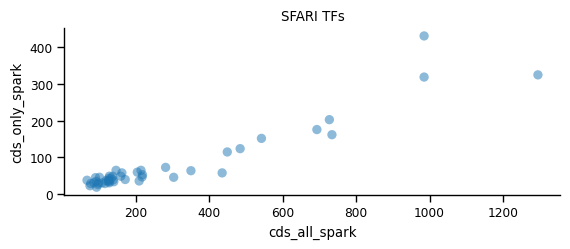

In [7]:
sns.set_context('paper')
sns.scatterplot(data = count_results, x = "cds_all_spark", y = "cds_only_spark", alpha = 0.5, s = 45, edgecolor = 'none')
sns.despine()
plt.gca().set_aspect('equal')
plt.title("SFARI TFs");

In [54]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [74]:
def plot_log_regplot_and_eq(data, x, y, log = True, scatter_color = sns.color_palette("tab10")[0], line_color = "gray", text_x = 0.1, text_y = 0.9):
    sns.set_context('talk')
    g = sns.regplot(data = data, x = x, y = y, 
                    scatter_kws = {'alpha' : 0.5, 's' : 20, 'color' : scatter_color}, 
                    line_kws = {'alpha' : 1, 'color' : line_color}, label = x.split("_")[0])

    extreme = max(max(data[x]), max(data[y]))
    
    if log:
        plt.xscale('log')
        plt.yscale('log')
    

    plt.gca().set_aspect('equal')
    # g.set_xlim(1, extreme)
    # g.set_ylim(1, extreme)
    
    sns.despine()
    pearson_r, _ = stats.pearsonr(data[x], data[y])

    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x], data[y])
    
    correlation_text = f"Pearson r = {pearson_r:.2f}"
    equation = f"y = {slope:.2f}x + {intercept:.2f}"
    
    plt.text(text_x, text_y, equation, transform=plt.gca().transAxes, fontsize=14, color=scatter_color)
    plt.text(text_x, text_y - 0.3, correlation_text, transform=plt.gca().transAxes, fontsize=14, color=scatter_color)


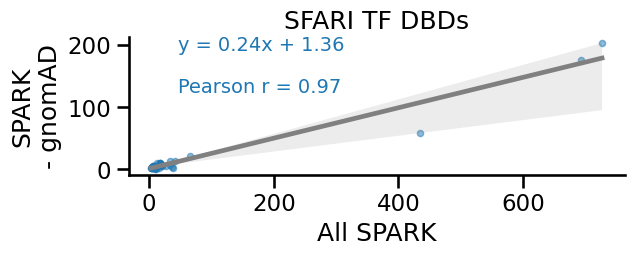

In [75]:
plot_log_regplot_and_eq(count_results, "DBD_all_spark", "DBD_only_spark", log = False)
plt.ylabel("SPARK\n- gnomAD")
plt.xlabel("All SPARK")
plt.title("SFARI TF DBDs");

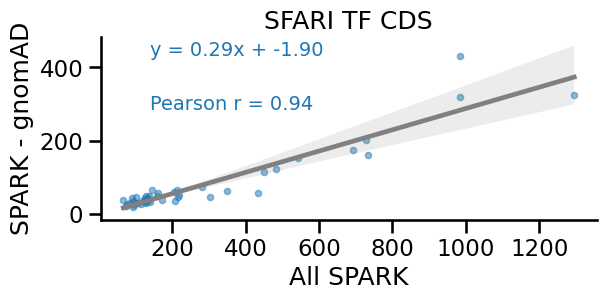

In [76]:
plot_log_regplot_and_eq(count_results, "cds_all_spark", "cds_only_spark", log = False)
plt.ylabel("SPARK - gnomAD")
plt.xlabel("All SPARK")
plt.title("SFARI TF CDS");

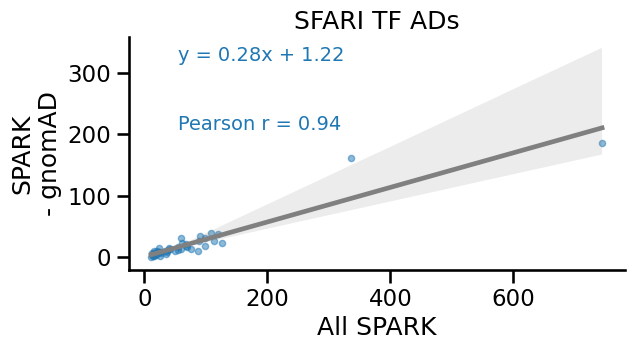

In [77]:
plot_log_regplot_and_eq(count_results, "AD_all_spark", "AD_only_spark", log = False)
plt.ylabel("SPARK\n- gnomAD")
plt.xlabel("All SPARK")
plt.title("SFARI TF ADs");

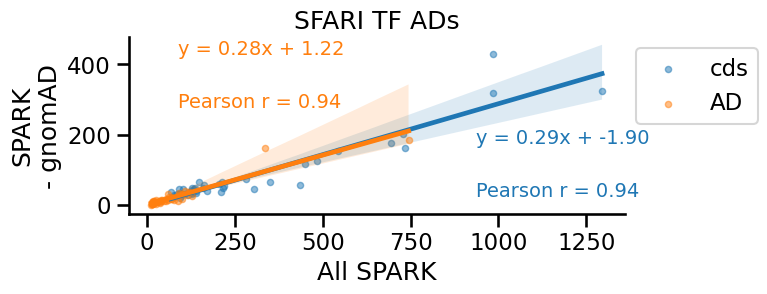

In [84]:
plot_log_regplot_and_eq(count_results, "cds_all_spark", "cds_only_spark", log = False,
                       scatter_color = sns.color_palette("tab10")[0], line_color = sns.color_palette("tab10")[0],
                       text_x = 0.7, text_y = 0.4)
plot_log_regplot_and_eq(count_results, "AD_all_spark", "AD_only_spark", log = False,
                       scatter_color = sns.color_palette("tab10")[1], line_color = sns.color_palette("tab10")[1]
                       )
plt.ylabel("SPARK\n- gnomAD")
plt.xlabel("All SPARK")
plt.title("SFARI TF ADs")

plt.legend()
sns.move_legend(plt.gca(), "upper left", bbox_to_anchor=(1, 1))


Running enrichment analysis pipeline

In [12]:
prior_enrich_analysis = pd.read_csv("../outputs/enrichment_analysis_summary_table.csv", index_col = 0)
prior_enrich_analysis

,gene-symbol,uniprotID,TF_cds_length,TF_missense,TF_missense_prop,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,DBD_missense_prop,RD_cds_length,RD_missense,RD_missense_prop,ADvsTF_fisher_exact_p_vals
0,ARNT2,Q9HBZ2,2154,217,0.100743,582,49,0.084192,162,8,0.049383,240,26,0.108333,1.261400e-01
1,ARX,Q96QS3,1689,146,0.086442,273,20,0.073260,171,3,0.017544,198,17,0.085859,4.800899e-01
2,AR,P10275,2763,219,0.079262,2259,182,0.080567,210,9,0.042857,750,88,0.117333,6.488056e-01
3,CASZ1,Q86V15,5280,734,0.139015,465,87,0.187097,825,65,0.078788,720,83,0.115278,2.479347e-03
4,CC2D1A,Q6P1N0,2856,435,0.152311,117,13,0.111111,2853,435,0.152471,0,0,NaN,2.376139e-01
5,CAMTA2,O94983,3609,449,0.124411,882,108,0.122449,339,18,0.053097,240,20,0.083333,8.604581e-01
6,EBF3,Q9H4W6,1791,138,0.077052,240,17,0.070833,693,34,0.049062,0,0,NaN,7.951436e-01
7,EGR3,Q06889,1164,101,0.086770,606,61,0.100660,213,12,0.056338,63,1,0.015873,9.507787e-02
8,ESR2,Q92731,1593,209,0.131199,1035,126,0.121739,210,27,0.128571,480,60,0.125000,1.394075e-01
9,GLIS1,Q8NBF1,1863,303,0.162641,522,75,0.143678,381,38,0.099738,240,23,0.095833,1.841198e-01


In [17]:
uniprot_ENST = pd.read_csv("../../data/SFARI_TFs_with_ENST_corrected.csv", index_col = 0)
uniprot_ENST["ENST"] = uniprot_ENST["ENST"].str.split(".").str[0]
uniprot_ENST

,uniprotID,ENST
0,Q9H2P0,ENST00000349014
1,Q5TGY3,ENST00000247087
2,Q96QS3,ENST00000379044
3,Q96JM3,ENST00000361283
4,Q96RK0,ENST00000575354
...,...,...
117,Q8NEK5,ENST00000366197
118,Q9BR84,ENST00000393883
119,Q68DY1,ENST00000601440
120,Q9Y462,ENST00000276123


In [18]:
count_results = pd.merge(count_results, uniprot_ENST, how = "left")
count_results

,ENST,cds_all_spark,cds_only_spark,AD_all_spark,AD_only_spark,DBD_all_spark,DBD_only_spark,uniprotID
0,ENST00000380013,693,176,60,13,693,176,Q6N021
1,ENST00000342988,77,29,40,15,8,6,Q13485
2,ENST00000241001,92,35,42,14,18,11,P26367
3,ENST00000056233,350,64,98,18,36,4,Q9Y4A8
4,ENST00000315869,128,49,90,34,3,2,P19532
5,ENST00000282549,108,31,67,22,9,3,P32242
6,ENST00000395324,171,40,20,9,34,7,P11473
7,ENST00000372583,985,431,336,162,17,10,Q5T1R4
8,ENST00000331340,162,58,36,9,10,2,Q13422
9,ENST00000348332,484,124,114,27,11,3,Q15788


In [19]:
full_tbl = pd.merge(count_results, prior_enrich_analysis, how = "left")
full_tbl

,ENST,cds_all_spark,cds_only_spark,AD_all_spark,AD_only_spark,DBD_all_spark,DBD_only_spark,uniprotID,gene-symbol,TF_cds_length,...,AD_cds_length,AD_missense,AD_missense_prop,DBD_cds_length,DBD_missense,DBD_missense_prop,RD_cds_length,RD_missense,RD_missense_prop,ADvsTF_fisher_exact_p_vals
0,ENST00000380013,693,176,60,13,693,176,Q6N021,TET2,6009.0,...,510.0,60.0,0.117647,6006.0,693.0,0.115385,0.0,0.0,NaN,8.847196e-01
1,ENST00000342988,77,29,40,15,8,6,Q13485,SMAD4,1659.0,...,927.0,40.0,0.043150,306.0,8.0,0.026144,540.0,16.0,0.029630,4.831769e-01
2,ENST00000241001,92,35,42,14,18,11,P26367,PAX6,1269.0,...,456.0,42.0,0.092105,546.0,18.0,0.032967,0.0,0.0,NaN,5.455985e-02
3,ENST00000056233,350,64,98,18,36,4,Q9Y4A8,NFE2L3,2085.0,...,600.0,98.0,0.163333,189.0,36.0,0.190476,510.0,105.0,0.205882,7.466316e-01
4,ENST00000315869,128,49,90,34,3,2,P19532,TFE3,1728.0,...,1059.0,90.0,0.084986,162.0,3.0,0.018519,0.0,0.0,NaN,3.017543e-02
5,ENST00000282549,108,31,67,22,9,3,P32242,OTX1,1065.0,...,549.0,67.0,0.122040,171.0,9.0,0.052632,0.0,0.0,NaN,2.517827e-02
6,ENST00000395324,171,40,20,9,34,7,P11473,VDR,1284.0,...,171.0,20.0,0.116959,210.0,34.0,0.161905,240.0,30.0,0.125000,5.477023e-01
7,ENST00000372583,985,431,336,162,17,10,Q5T1R4,HIVEP3,7221.0,...,2592.0,336.0,0.129630,282.0,17.0,0.060284,270.0,21.0,0.077778,2.112343e-01
8,ENST00000331340,162,58,36,9,10,2,Q13422,IKZF1,1560.0,...,246.0,36.0,0.146341,279.0,10.0,0.035842,0.0,0.0,NaN,2.231205e-02
9,ENST00000348332,484,124,114,27,11,3,Q15788,NCOA1,4326.0,...,1230.0,114.0,0.092683,168.0,11.0,0.065476,810.0,69.0,0.085185,1.191144e-02


In [20]:
full_tbl.columns

Index(['ENST', 'cds_all_spark', 'cds_only_spark', 'AD_all_spark',
       'AD_only_spark', 'DBD_all_spark', 'DBD_only_spark', 'uniprotID',
       'gene-symbol', 'TF_cds_length', 'TF_missense', 'TF_missense_prop',
       'AD_cds_length', 'AD_missense', 'AD_missense_prop', 'DBD_cds_length',
       'DBD_missense', 'DBD_missense_prop', 'RD_cds_length', 'RD_missense',
       'RD_missense_prop', 'ADvsTF_fisher_exact_p_vals'],
      dtype='object')

In [21]:
full_tbl_subset = full_tbl[["gene-symbol", "uniprotID", "TF_cds_length", "cds_only_spark", "AD_cds_length", "AD_only_spark", "DBD_cds_length", "DBD_only_spark"]].dropna().sort_values(by = "gene-symbol")
full_tbl_subset = full_tbl_subset.rename(columns = {"cds_only_spark" : "TF_missense", "AD_only_spark" : "AD_missense", "DBD_only_spark": "DBD_missense"})
full_tbl_subset

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense
36,ARNT2,Q9HBZ2,2154.0,47,582.0,10,162.0,2
37,ARX,Q96QS3,1689.0,65,273.0,10,171.0,2
22,CAMTA2,O94983,3609.0,115,882.0,39,339.0,8
34,CASZ1,Q86V15,5280.0,162,465.0,10,825.0,21
27,CC2D1A,Q6P1N0,2856.0,58,117.0,3,2853.0,58
13,EBF3,Q9H4W6,1791.0,39,240.0,7,693.0,13
38,EGR3,Q06889,1164.0,46,606.0,23,213.0,10
24,ERG,P11308,1440.0,31,573.0,16,240.0,2
42,ESR2,Q92731,1593.0,36,1035.0,24,210.0,6
33,GLIS1,Q8NBF1,1863.0,46,522.0,13,381.0,2


In [27]:
full_tbl_subset["TF_missense_prop"] = full_tbl_subset["TF_missense"] / full_tbl_subset["TF_cds_length"]
full_tbl_subset["AD_missense_prop"] = full_tbl_subset["AD_missense"] / full_tbl_subset["AD_cds_length"]
full_tbl_subset["DBD_missense_prop"] = full_tbl_subset["DBD_missense"] / full_tbl_subset["DBD_cds_length"]
full_tbl_subset = full_tbl_subset.reset_index(drop = True)
full_tbl_subset

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop
0,ARNT2,Q9HBZ2,2154.0,47,582.0,10,162.0,2,0.021820,0.017182,0.012346
1,ARX,Q96QS3,1689.0,65,273.0,10,171.0,2,0.038484,0.036630,0.011696
2,CAMTA2,O94983,3609.0,115,882.0,39,339.0,8,0.031865,0.044218,0.023599
3,CASZ1,Q86V15,5280.0,162,465.0,10,825.0,21,0.030682,0.021505,0.025455
4,CC2D1A,Q6P1N0,2856.0,58,117.0,3,2853.0,58,0.020308,0.025641,0.020329
5,EBF3,Q9H4W6,1791.0,39,240.0,7,693.0,13,0.021776,0.029167,0.018759
6,EGR3,Q06889,1164.0,46,606.0,23,213.0,10,0.039519,0.037954,0.046948
7,ERG,P11308,1440.0,31,573.0,16,240.0,2,0.021528,0.027923,0.008333
8,ESR2,Q92731,1593.0,36,1035.0,24,210.0,6,0.022599,0.023188,0.028571
9,GLIS1,Q8NBF1,1863.0,46,522.0,13,381.0,2,0.024691,0.024904,0.005249


AD vs TF first

In [32]:
Variant_analysis_helper_functions.add_fisher_p_vals_vs_control(full_tbl_subset, "AD")

display(full_tbl_subset)
decisions = Variant_analysis_helper_functions.benjamini_hochberg(full_tbl_subset["ADvsTF_fisher_exact_p_vals"], 0.1)
sig_output = full_tbl_subset[decisions]
sig_output

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop,ADvsTF_fisher_exact_p_vals
0,ARNT2,Q9HBZ2,2154.0,47,582.0,10,162.0,2,0.021820,0.017182,0.012346,0.411466
1,ARX,Q96QS3,1689.0,65,273.0,10,171.0,2,0.038484,0.036630,0.011696,1.000000
2,CAMTA2,O94983,3609.0,115,882.0,39,339.0,8,0.031865,0.044218,0.023599,0.020222
3,CASZ1,Q86V15,5280.0,162,465.0,10,825.0,21,0.030682,0.021505,0.025455,0.261650
4,CC2D1A,Q6P1N0,2856.0,58,117.0,3,2853.0,58,0.020308,0.025641,0.020329,0.513185
5,EBF3,Q9H4W6,1791.0,39,240.0,7,693.0,13,0.021776,0.029167,0.018759,0.349113
6,EGR3,Q06889,1164.0,46,606.0,23,213.0,10,0.039519,0.037954,0.046948,0.880518
7,ERG,P11308,1440.0,31,573.0,16,240.0,2,0.021528,0.027923,0.008333,0.195761
8,ESR2,Q92731,1593.0,36,1035.0,24,210.0,6,0.022599,0.023188,0.028571,1.000000
9,GLIS1,Q8NBF1,1863.0,46,522.0,13,381.0,2,0.024691,0.024904,0.005249,1.000000


,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop,ADvsTF_fisher_exact_p_vals


In [38]:
# No genes have enriched ADs relative to TFs!

---
AD vs DBD

In [33]:
contains_DBD = full_tbl_subset[full_tbl_subset["DBD_cds_length"] != 0]
contains_DBD = contains_DBD.reset_index(drop = True)
contains_DBD

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop,ADvsTF_fisher_exact_p_vals
0,ARNT2,Q9HBZ2,2154.0,47,582.0,10,162.0,2,0.021820,0.017182,0.012346,0.411466
1,ARX,Q96QS3,1689.0,65,273.0,10,171.0,2,0.038484,0.036630,0.011696,1.000000
2,CAMTA2,O94983,3609.0,115,882.0,39,339.0,8,0.031865,0.044218,0.023599,0.020222
3,CASZ1,Q86V15,5280.0,162,465.0,10,825.0,21,0.030682,0.021505,0.025455,0.261650
4,CC2D1A,Q6P1N0,2856.0,58,117.0,3,2853.0,58,0.020308,0.025641,0.020329,0.513185
5,EBF3,Q9H4W6,1791.0,39,240.0,7,693.0,13,0.021776,0.029167,0.018759,0.349113
6,EGR3,Q06889,1164.0,46,606.0,23,213.0,10,0.039519,0.037954,0.046948,0.880518
7,ERG,P11308,1440.0,31,573.0,16,240.0,2,0.021528,0.027923,0.008333,0.195761
8,ESR2,Q92731,1593.0,36,1035.0,24,210.0,6,0.022599,0.023188,0.028571,1.000000
9,GLIS1,Q8NBF1,1863.0,46,522.0,13,381.0,2,0.024691,0.024904,0.005249,1.000000


In [34]:
Variant_analysis_helper_functions.add_fisher_p_vals_vs_control(contains_DBD, "AD", "DBD")

[[10, 2], [572.0, 160.0]]
[[10, 2], [263.0, 169.0]]
[[39, 8], [843.0, 331.0]]
[[10, 21], [455.0, 804.0]]
[[3, 58], [114.0, 2795.0]]
[[7, 13], [233.0, 680.0]]
[[23, 10], [583.0, 203.0]]
[[16, 2], [557.0, 238.0]]
[[24, 6], [1011.0, 204.0]]
[[13, 2], [509.0, 379.0]]
[[162, 10], [2430.0, 272.0]]
[[9, 2], [237.0, 277.0]]
[[12, 6], [258.0, 249.0]]
[[2, 6], [130.0, 213.0]]
[[7, 2], [293.0, 217.0]]
[[15, 2], [405.0, 142.0]]
[[32, 3], [1129.0, 141.0]]
[[18, 4], [396.0, 170.0]]
[[2, 2], [100.0, 169.0]]
[[31, 9], [860.0, 441.0]]
[[17, 7], [805.0, 545.0]]
[[27, 3], [1203.0, 165.0]]
[[18, 4], [582.0, 185.0]]
[[1, 10], [248.0, 305.0]]
[[7, 8], [260.0, 307.0]]
[[6, 4], [156.0, 167.0]]
[[27, 4], [807.0, 209.0]]
[[10, 6], [308.0, 204.0]]
[[22, 3], [527.0, 168.0]]
[[2, 1], [163.0, 374.0]]
[[14, 11], [442.0, 535.0]]
[[8, 3], [142.0, 168.0]]
[[3, 5], [339.0, 205.0]]
[[15, 6], [912.0, 300.0]]
[[185, 1], [5527.0, 116.0]]
[[4, 13], [236.0, 557.0]]
[[38, 203], [943.0, 5677.0]]
[[8, 4], [475.0, 158.0]]
[[6, 5]

In [35]:
contains_DBD.sort_values(by = "ADvsDBD_fisher_exact_p_vals")

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop,ADvsTF_fisher_exact_p_vals,ADvsDBD_fisher_exact_p_vals
23,NFIA,Q12857,1530.0,30,249.0,1,315.0,10,0.019608,0.004016,0.031746,0.074629,0.027303
11,IKZF1,Q13422,1560.0,58,246.0,9,279.0,2,0.037179,0.036585,0.007168,1.000000,0.028726
9,GLIS1,Q8NBF1,1863.0,46,522.0,13,381.0,2,0.024691,0.024904,0.005249,1.000000,0.031678
10,HIVEP3,Q5T1R4,7221.0,431,2592.0,162,282.0,10,0.059687,0.062500,0.035461,0.468570,0.084132
2,CAMTA2,O94983,3609.0,115,882.0,39,339.0,8,0.031865,0.044218,0.023599,0.020222,0.099090
7,ERG,P11308,1440.0,31,573.0,16,240.0,2,0.021528,0.027923,0.008333,0.195761,0.115280
31,PITX1,P78337,945.0,36,150.0,8,171.0,3,0.038095,0.053333,0.017544,0.348565,0.121889
1,ARX,Q96QS3,1689.0,65,273.0,10,171.0,2,0.038484,0.036630,0.011696,1.000000,0.140924
19,MTF1,Q14872,2262.0,65,891.0,31,450.0,9,0.028736,0.034792,0.020000,0.197354,0.173120
34,SRCAP,Q6ZRS2,9693.0,325,5712.0,185,117.0,1,0.033529,0.032388,0.008547,0.456509,0.186258


In [36]:
contains_DBD_sig = Variant_analysis_helper_functions.return_bh_sig(contains_DBD, "ADvsDBD_fisher_exact_p_vals", 0.1)
contains_DBD_sig

,gene-symbol,uniprotID,TF_cds_length,TF_missense,AD_cds_length,AD_missense,DBD_cds_length,DBD_missense,TF_missense_prop,AD_missense_prop,DBD_missense_prop,ADvsTF_fisher_exact_p_vals,ADvsDBD_fisher_exact_p_vals


In [39]:
# No genes have enriched ADs relative to DBDs!